In [1]:
import numpy as np

# Save fonts into pdf
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42


import matplotlib.pyplot as plt
import tqdm.notebook
import scipy.integrate

In [11]:
matplotlib.rcParams.update({'font.size': 8, 'axes.linewidth': 0.5, 'xtick.major.width': 0.5, 'xtick.minor.width': 0.5, 
                            'ytick.major.width': 0.5,'ytick.minor.width': 0.5, 'xtick.major.pad':2,'ytick.major.pad':2})
matplotlib.rcParams.update({'font.family':'sans-serif','font.sans-serif':['Arial'], 'mathtext.default':'sf','mathtext.fontset':'custom'})

matplotlib.rcParams.update({'savefig.transparent':True})

In [3]:
dt = 1e-4
T_max = 0.2
t = np.arange(0, int(T_max/dt))*dt

# Probability distributions

## i – unimodal

In [5]:
uni_distr = np.exp(-(t-0.12)**2/(2*0.0075**2))
uni_distr /=np.sum(uni_distr)

In [6]:
uni_cdf = np.cumsum(uni_distr)
get_interval_uni = lambda r: np.interp(r, uni_cdf, t)

## ii – bimodal

In [7]:
# Use example bimodal distribution (see text)
bimodal_distr = np.exp(-(t-0.05)**2/(2*0.05**2)) + 2*np.exp(-(t-0.15)**2/(2*0.01**2))
bimodal_distr /=np.sum(bimodal_distr)

bimodal_cdf = np.cumsum(bimodal_distr)
get_interval_bi = lambda r: np.interp(r, bimodal_cdf, t)

## iii – unimodal + background

In [8]:
uniform_distr = np.ones(len(t))
uniform_distr /= np.sum(uniform_distr)

peak_weight = 0.1
peaked_distr = peak_weight*uni_distr + (1-peak_weight)*uniform_distr

In [40]:
# uniform_cdf = np.cumsum(uniform_distr)
peaked_cdf = np.cumsum(peaked_distr)
get_interval_peaked = lambda r: np.interp(r, peaked_cdf, t)

## iv -- distribution from integrated simulation

In [345]:
empirical_distr = np.load('../behavior-learning/files/integrated simulation/poisson-low-example-hist-simple.npy')

In [357]:
empirical_cdf = np.cumsum(empirical_distr)
t_empirical = np.linspace(0, 0.2, 100)
get_interval_empirical = lambda r: np.interp(r, empirical_cdf, t_empirical)

In [ ]:
empirical_dense = np.interp(t, t_empirical, empirical_cdf)

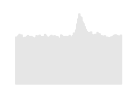

In [426]:
plt.figure(figsize=(1.5,1))

plt.fill_between(t[:-1], np.zeros(len(t)-1), t[1]*(empirical_dense[1:]-empirical_dense[:-1]), color=(0.9,)*3)
plt.axis('off')
plt.savefig('figures/empirical-pdf.pdf')

# Timer adjustment (broad) – ideal

In [355]:
idealized_integrator = lambda t, t_p: np.exp(-(t-t_p)**2/(2*0.0025**2))

def simulateTimerAdjustment(get_interval, N_sims = 10, its = 5000, dtp_ = 1e-3, min_tp = 0, max_tp = T_max):
    tps = np.zeros((N_sims, its))
    # cdf = np.cumsum(distr)
    # get_interval = lambda r: np.interp(r, cdf, t)

    for n in tqdm.notebook.trange(N_sims):
        integrator = idealized_integrator(t, min_tp)

        tps[n, 0] = min_tp
        for it in tqdm.notebook.trange(its-1, leave=False):
            cf_time = get_interval(rng.random())

            # Idealized ATTRAP rule: lower threshold if CF occurs before current peak time
            # and raise threshold if CF occurs after current peak time
            lower_tp = -1*(cf_time < tps[n, it])
            raise_tp = cf_time > tps[n, it]

            dtp = (lower_tp+raise_tp)*dtp_
            tps[n,it+1] = np.minimum(np.maximum(tps[n,it] + dtp, min_tp), max_tp)

            integrator = idealized_integrator(t, tps[n, it+1])
    return tps

## i – unimodal distribution

In [48]:
rng = np.random.default_rng(0)
tps_ideal = simulateTimerAdjustment(get_interval_uni)

tps_ideal_mu = np.mean(tps_ideal, axis=0)
tps_ideal_std = np.std(tps_ideal, axis=0)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/4999 [00:00<?, ?it/s]

  0%|          | 0/4999 [00:00<?, ?it/s]

  0%|          | 0/4999 [00:00<?, ?it/s]

  0%|          | 0/4999 [00:00<?, ?it/s]

  0%|          | 0/4999 [00:00<?, ?it/s]

  0%|          | 0/4999 [00:00<?, ?it/s]

  0%|          | 0/4999 [00:00<?, ?it/s]

  0%|          | 0/4999 [00:00<?, ?it/s]

  0%|          | 0/4999 [00:00<?, ?it/s]

  0%|          | 0/4999 [00:00<?, ?it/s]

([<matplotlib.axis.YTick at 0x7fd4f1aca3b0>,
 [Text(0, 0.0, '0'), Text(0, 0.1, ''), Text(0, 0.2, '200')])

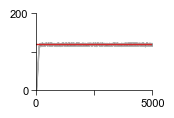

In [49]:
plt.figure(figsize=(1.5,1))
plt.fill_between(np.arange(5000),tps_ideal_mu-tps_ideal_std, tps_ideal_mu+tps_ideal_std, color='k', alpha=0.3, linewidth=None )
plt.plot([0, 5000], [0.12,]*2, c='C3', lw=1)
plt.xlim([0, 5000])
plt.ylim([0, 0.2])
plt.xticks([0, 2500, 5000], [0,'',5000])
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.yticks([0, 0.1, 0.2], [0, '', 200])

In [32]:
np.mean(tps_ideal_mu[-1000:])

0.12006920000000008

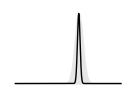

In [52]:
plt.figure(figsize=(1.5,1))

plt.fill_between(t, np.zeros(len(t)), uni_distr, color=(0.9,)*3)
plt.axis('off')
ax = plt.twinx()
# ax.plot(t, idealized_integrator(t, t_p_init_avg), c='k')
ax.plot(t, idealized_integrator(t, np.mean(tps_ideal_mu[-1000:])), c='k',lw=1)
plt.axis('off');
plt.savefig('figures/unimodal-median-ideal.pdf')

## ii – bimodal distribution

In [58]:
rng = np.random.default_rng(0)
tps_ideal = simulateTimerAdjustment(get_interval_bi)

tps_ideal_mu = np.mean(tps_ideal, axis=0)
tps_ideal_std = np.std(tps_ideal, axis=0)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/4999 [00:00<?, ?it/s]

  0%|          | 0/4999 [00:00<?, ?it/s]

  0%|          | 0/4999 [00:00<?, ?it/s]

  0%|          | 0/4999 [00:00<?, ?it/s]

  0%|          | 0/4999 [00:00<?, ?it/s]

  0%|          | 0/4999 [00:00<?, ?it/s]

  0%|          | 0/4999 [00:00<?, ?it/s]

  0%|          | 0/4999 [00:00<?, ?it/s]

  0%|          | 0/4999 [00:00<?, ?it/s]

  0%|          | 0/4999 [00:00<?, ?it/s]

In [77]:
true_median = get_interval_bi(0.5)

([<matplotlib.axis.YTick at 0x7fd4f1e0c0d0>,
 [Text(0, 0.0, '0'), Text(0, 0.1, ''), Text(0, 0.2, '200')])

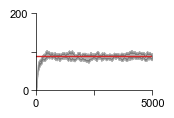

In [60]:
plt.figure(figsize=(1.5,1))
plt.fill_between(np.arange(5000),tps_ideal_mu-tps_ideal_std, tps_ideal_mu+tps_ideal_std, color='k', alpha=0.3, linewidth=None )
plt.plot([0, 5000], [true_median,]*2, c='C3', lw=1)
plt.xlim([0, 5000])
plt.ylim([0, 0.2])
plt.xticks([0, 2500, 5000], [0,'',5000])
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.yticks([0, 0.1, 0.2], [0, '', 200])

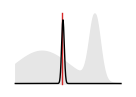

In [65]:
plt.figure(figsize=(1.5,1))
plt.fill_between(t, np.zeros(len(t)), bimodal_distr, color=(0.9,)*3)
plt.axis('off')
ax = plt.twinx()
# ax.plot(t, idealized_integrator(t, t_p_init_avg), c='k')
plt.plot([true_median,]*2, [0, 1.1], lw=1, c='C3')
ax.plot(t, idealized_integrator(t, np.mean(tps_ideal_mu[-1000:])), c='k',lw=1)
plt.axis('off');
plt.savefig('figures/bimodal-median-ideal.pdf')

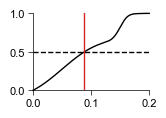

In [78]:
plt.figure(figsize=(1.5,1))
plt.plot(t, bimodal_cdf, c='k',clip_on=False,lw=1)
plt.plot([0,t[-1]], [0.5, 0.5], c='k',lw=1,ls='--')
plt.plot([true_median,]*2, [0, 1], lw=1, c='C3')
plt.xlim([0,0.2])
plt.ylim([0,1])
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.set_yticks([0,0.5,1])
ax.set_xticks([0,0.1,0.2])
# plt.axis('off')
plt.savefig('figures/bimodal-cdf-median.pdf')

## iii -- peak + background

In [66]:
rng = np.random.default_rng(0)
tps_ideal = simulateTimerAdjustment(get_interval_peaked)

tps_ideal_mu = np.mean(tps_ideal, axis=0)
tps_ideal_std = np.std(tps_ideal, axis=0)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/4999 [00:00<?, ?it/s]

  0%|          | 0/4999 [00:00<?, ?it/s]

  0%|          | 0/4999 [00:00<?, ?it/s]

  0%|          | 0/4999 [00:00<?, ?it/s]

  0%|          | 0/4999 [00:00<?, ?it/s]

  0%|          | 0/4999 [00:00<?, ?it/s]

  0%|          | 0/4999 [00:00<?, ?it/s]

  0%|          | 0/4999 [00:00<?, ?it/s]

  0%|          | 0/4999 [00:00<?, ?it/s]

  0%|          | 0/4999 [00:00<?, ?it/s]

In [67]:
true_median = get_interval_peaked(0.5)

([<matplotlib.axis.YTick at 0x7fd4f03d2f80>,
 [Text(0, 0.0, '0'), Text(0, 0.1, ''), Text(0, 0.2, '200')])

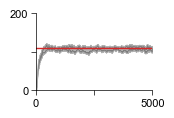

In [42]:
plt.figure(figsize=(1.5,1))
plt.fill_between(np.arange(5000),tps_ideal_mu-tps_ideal_std, tps_ideal_mu+tps_ideal_std, color='k', alpha=0.3, linewidth=None )
plt.plot([0, 5000], [true_median,]*2, c='C3', lw=1)
plt.xlim([0, 5000])
plt.ylim([0, 0.2])
plt.xticks([0, 2500, 5000], [0,'',5000])
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.yticks([0, 0.1, 0.2], [0, '', 200])

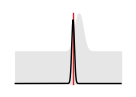

In [68]:
plt.figure(figsize=(1.5,1))

plt.fill_between(t, np.zeros(len(t)), peaked_distr, color=(0.9,)*3)
plt.axis('off')
ax = plt.twinx()
# ax.plot(t, idealized_integrator(t, t_p_init_avg), c='k')
plt.plot([true_median,]*2, [0, 1.1], lw=1, c='C3')
ax.plot(t, idealized_integrator(t, np.mean(tps_ideal_mu[-1000:])), c='k',lw=1)
plt.axis('off');
plt.savefig('figures/peaked-median-ideal.pdf')

## iv -- empirical distr

In [358]:
rng = np.random.default_rng(0)
tps_ideal = simulateTimerAdjustment(get_interval_empirical)

tps_ideal_mu = np.mean(tps_ideal, axis=0)
tps_ideal_std = np.std(tps_ideal, axis=0)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/4999 [00:00<?, ?it/s]

  0%|          | 0/4999 [00:00<?, ?it/s]

  0%|          | 0/4999 [00:00<?, ?it/s]

  0%|          | 0/4999 [00:00<?, ?it/s]

  0%|          | 0/4999 [00:00<?, ?it/s]

  0%|          | 0/4999 [00:00<?, ?it/s]

  0%|          | 0/4999 [00:00<?, ?it/s]

  0%|          | 0/4999 [00:00<?, ?it/s]

  0%|          | 0/4999 [00:00<?, ?it/s]

  0%|          | 0/4999 [00:00<?, ?it/s]

In [359]:
true_median = get_interval_empirical(0.5)

([<matplotlib.axis.YTick at 0x7fd4df81f1c0>,
 [Text(0, 0.0, '0'), Text(0, 0.1, ''), Text(0, 0.2, '200')])

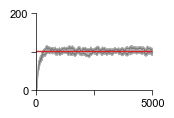

In [360]:
plt.figure(figsize=(1.5,1))
plt.fill_between(np.arange(5000),tps_ideal_mu-tps_ideal_std, tps_ideal_mu+tps_ideal_std, color='k', alpha=0.3, linewidth=None )
plt.plot([0, 5000], [true_median,]*2, c='C3', lw=1)
plt.xlim([0, 5000])
plt.ylim([0, 0.2])
plt.xticks([0, 2500, 5000], [0,'',5000])
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.yticks([0, 0.1, 0.2], [0, '', 200])

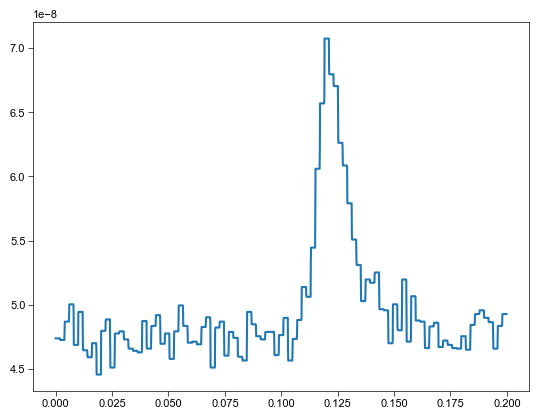

In [368]:
# plt.plot(t_empirical[:-1], t_empirical[1]*(empirical_cdf[1:] - empirical_cdf[:-1]))
plt.plot(t[:-1], t[1]*(empirical_dense[1:]-empirical_dense[:-1]))

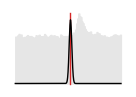

In [370]:
plt.figure(figsize=(1.5,1))

# plt.fill_between(t_empirical, np.zeros(len(t_empirical)), empirical_distr, color=(0.9,)*3)
plt.fill_between(t[:-1], np.zeros(len(t)-1), t[1]*(empirical_dense[1:]-empirical_dense[:-1]), color=(0.9,)*3)
plt.axis('off')
ax = plt.twinx()
# ax.plot(t, idealized_integrator(t, t_p_init_avg), c='k')
plt.plot([true_median,]*2, [0, 1.1], lw=1, c='C3')
ax.plot(t, idealized_integrator(t, np.mean(tps_ideal_mu[-1000:])), c='k',lw=1)
plt.axis('off');
plt.savefig('figures/empirical-median-ideal.pdf')

# Timer adjustment (narrow)

In [372]:
idealized_integrator = lambda t, t_p: np.exp(-(t-t_p)**2/(2*0.0025**2))

def simulateTimerAdjustmentPeak(get_interval, N_sims = 10, its = 5000, dtp_ = 1e-3, min_tp = 0, max_tp = T_max,
                               window_left = 20e-3, window_right = 20e-3, median_weight = 0.01, initial_value = None):
    tps = np.zeros((N_sims, its))
    # cdf = np.cumsum(distr)
    # get_interval = lambda r: np.interp(r, cdf, t)
    
    if initial_value == None:
        initial_value = min_tp

    for n in tqdm.notebook.trange(N_sims):
        integrator = idealized_integrator(t, min_tp)

        tps[n, 0] = initial_value
        for it in tqdm.notebook.trange(its-1, leave=False):
            cf_time = get_interval(np.random.rand())

            # Idealized ATTRAP rule: lower threshold if CF occurs before current peak time
            # and raise threshold if CF occurs after current peak time
            lower_tp_med = -1*(cf_time < tps[n, it])
            raise_tp_med = cf_time > tps[n, it]

            dtp_med = lower_tp_med+raise_tp_med
            
            lower_tp_window = -1*(tps[n,it]-window_left < cf_time < tps[n, it])
            raise_tp_window = tps[n, it] < cf_time < tps[n,it] + window_right
            
            dtp_window = lower_tp_window+raise_tp_window
            
            dtp = dtp_*(median_weight*dtp_med + (1-median_weight)*dtp_window)
            tps[n,it+1] = np.minimum(np.maximum(tps[n,it] + dtp, min_tp), max_tp)

            integrator = idealized_integrator(t, tps[n, it+1])
    return tps

## i -- unimodal

In [373]:
its=10000

In [84]:
rng = np.random.default_rng(0)
tps_ideal = simulateTimerAdjustmentPeak(get_interval_uni,dtp_=2e-3, its=its)

tps_ideal_mu = np.mean(tps_ideal, axis=0)
tps_ideal_std = np.std(tps_ideal, axis=0)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/9999 [00:00<?, ?it/s]

  0%|          | 0/9999 [00:00<?, ?it/s]

  0%|          | 0/9999 [00:00<?, ?it/s]

  0%|          | 0/9999 [00:00<?, ?it/s]

  0%|          | 0/9999 [00:00<?, ?it/s]

  0%|          | 0/9999 [00:00<?, ?it/s]

  0%|          | 0/9999 [00:00<?, ?it/s]

  0%|          | 0/9999 [00:00<?, ?it/s]

  0%|          | 0/9999 [00:00<?, ?it/s]

  0%|          | 0/9999 [00:00<?, ?it/s]

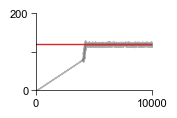

In [86]:
plt.figure(figsize=(1.5,1))
plt.fill_between(np.arange(its),tps_ideal_mu-tps_ideal_std, tps_ideal_mu+tps_ideal_std, color='k', alpha=0.3, linewidth=None )
plt.plot([0, its], [0.12,]*2, c='C3', lw=1)
plt.xlim([0, its])
plt.ylim([0, 0.2])
plt.xticks(np.linspace(0,its,2))
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.yticks([0, 0.1, 0.2], [0, '', 200]);

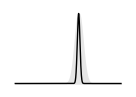

In [88]:
plt.figure(figsize=(1.5,1))

plt.fill_between(t, np.zeros(len(t)), uni_distr, color=(0.9,)*3)
plt.axis('off')
ax = plt.twinx()
# ax.plot(t, idealized_integrator(t, t_p_init_avg), c='k')
ax.plot(t, idealized_integrator(t, np.mean(tps_ideal_mu[-1000:])), c='k',lw=1)
plt.axis('off');
plt.savefig('figures/unimodal-peak-ideal.pdf')

## ii -- bimodal

In [90]:
rng = np.random.default_rng(0)
tps_ideal = simulateTimerAdjustmentPeak(get_interval_bi, dtp_=2e-3, its=its)

tps_ideal_mu = np.mean(tps_ideal, axis=0)
tps_ideal_std = np.std(tps_ideal, axis=0)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/9999 [00:00<?, ?it/s]

  0%|          | 0/9999 [00:00<?, ?it/s]

  0%|          | 0/9999 [00:00<?, ?it/s]

  0%|          | 0/9999 [00:00<?, ?it/s]

  0%|          | 0/9999 [00:00<?, ?it/s]

  0%|          | 0/9999 [00:00<?, ?it/s]

  0%|          | 0/9999 [00:00<?, ?it/s]

  0%|          | 0/9999 [00:00<?, ?it/s]

  0%|          | 0/9999 [00:00<?, ?it/s]

  0%|          | 0/9999 [00:00<?, ?it/s]

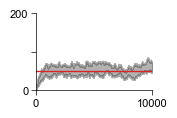

In [92]:
plt.figure(figsize=(1.5,1))
plt.fill_between(np.arange(its),tps_ideal_mu-tps_ideal_std, tps_ideal_mu+tps_ideal_std, color='k', alpha=0.3, linewidth=None )
plt.plot([0, its], [0.05,]*2, c='C3', lw=1)
plt.xlim([0, its])
plt.ylim([0, 0.2])
plt.xticks(np.linspace(0,its,2))
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.yticks([0, 0.1, 0.2], [0, '', 200]);

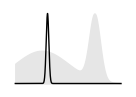

In [93]:
plt.figure(figsize=(1.5,1))
plt.fill_between(t, np.zeros(len(t)), bimodal_distr, color=(0.9,)*3)
plt.axis('off')
ax = plt.twinx()
# ax.plot(t, idealized_integrator(t, t_p_init_avg), c='k')
ax.plot(t, idealized_integrator(t, np.mean(tps_ideal_mu[-1000:])), c='k',lw=1)
plt.axis('off');
plt.savefig('figures/bimodal-peak-ideal.pdf')

## iii -- peaked

In [101]:
its = 12000

In [102]:
rng = np.random.default_rng(0)
tps_ideal = simulateTimerAdjustmentPeak(get_interval_peaked, dtp_=2e-3, its=its)

tps_ideal_mu = np.mean(tps_ideal, axis=0)
tps_ideal_std = np.std(tps_ideal, axis=0)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/11999 [00:00<?, ?it/s]

  0%|          | 0/11999 [00:00<?, ?it/s]

  0%|          | 0/11999 [00:00<?, ?it/s]

  0%|          | 0/11999 [00:00<?, ?it/s]

  0%|          | 0/11999 [00:00<?, ?it/s]

  0%|          | 0/11999 [00:00<?, ?it/s]

  0%|          | 0/11999 [00:00<?, ?it/s]

  0%|          | 0/11999 [00:00<?, ?it/s]

  0%|          | 0/11999 [00:00<?, ?it/s]

  0%|          | 0/11999 [00:00<?, ?it/s]

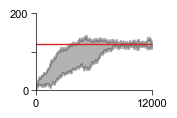

In [103]:
plt.figure(figsize=(1.5,1))
plt.fill_between(np.arange(its),tps_ideal_mu-tps_ideal_std, tps_ideal_mu+tps_ideal_std, color='k', alpha=0.3, linewidth=None )
plt.plot([0, its], [0.12,]*2, c='C3', lw=1)
plt.xlim([0, its])
plt.ylim([0, 0.2])
plt.xticks(np.linspace(0,its,2))
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.yticks([0, 0.1, 0.2], [0, '', 200]);

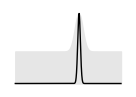

In [104]:
plt.figure(figsize=(1.5,1))
plt.fill_between(t, np.zeros(len(t)), peaked_distr, color=(0.9,)*3)
plt.axis('off')
ax = plt.twinx()
# ax.plot(t, idealized_integrator(t, t_p_init_avg), c='k')
ax.plot(t, idealized_integrator(t, np.mean(tps_ideal_mu[-1000:])), c='k',lw=1)
plt.axis('off');
plt.savefig('figures/peaked-peak-ideal.pdf')

## iv -- empirical

In [401]:
its = 40000

In [402]:
rng = np.random.default_rng(0)
tps_ideal = simulateTimerAdjustmentPeak(get_interval_empirical, dtp_=1e-3, its=its)

tps_ideal_mu = np.mean(tps_ideal, axis=0)
tps_ideal_std = np.std(tps_ideal, axis=0)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/39999 [00:00<?, ?it/s]

  0%|          | 0/39999 [00:00<?, ?it/s]

  0%|          | 0/39999 [00:00<?, ?it/s]

  0%|          | 0/39999 [00:00<?, ?it/s]

  0%|          | 0/39999 [00:00<?, ?it/s]

  0%|          | 0/39999 [00:00<?, ?it/s]

  0%|          | 0/39999 [00:00<?, ?it/s]

  0%|          | 0/39999 [00:00<?, ?it/s]

  0%|          | 0/39999 [00:00<?, ?it/s]

  0%|          | 0/39999 [00:00<?, ?it/s]

In [397]:
empirical_pdf = t[1]*(empirical_dense[1:]-empirical_dense[:-1])

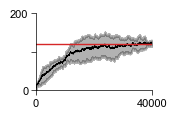

In [408]:
plt.figure(figsize=(1.5,1))
plt.fill_between(np.arange(its),tps_ideal_mu-tps_ideal_std, tps_ideal_mu+tps_ideal_std, color='k', alpha=0.3, linewidth=None )
plt.plot(np.arange(its),tps_ideal_mu, color='k', lw=0.5 )
plt.plot([0, its], [t[np.argmax(empirical_pdf)],]*2, c='C3', lw=1)
plt.xlim([0, its])
plt.ylim([0, 0.2])
plt.xticks(np.linspace(0,its,2))
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.yticks([0, 0.1, 0.2], [0, '', 200]);

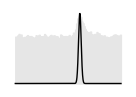

In [405]:
plt.figure(figsize=(1.5,1))
plt.fill_between(t[:-1], np.zeros(len(t)-1), empirical_pdf, color=(0.9,)*3)
plt.axis('off')
ax = plt.twinx()
# ax.plot(t, idealized_integrator(t, t_p_init_avg), c='k')
ax.plot(t, idealized_integrator(t, np.mean(tps_ideal_mu[-1000:])), c='k',lw=1)
plt.axis('off');
plt.savefig('figures/empirical-peak-ideal.pdf')

# Timer selection (mode)

In [ ]:
hill = lambda x, k_d, n: np.power(x,n)/(k_d**n + np.power(x,n))

In [409]:
num_ideal_timers = 50 # 16
timer_std = 2.5e-3
timers = np.zeros((num_ideal_timers, len(t)))
centers = np.linspace(0, 0.2, num_ideal_timers)
for i in range(num_ideal_timers):
#     timers[i,:] = hill(np.exp(-(t - centers[i])**2/(2*timer_std**2)),0.5,10)
#     timers[i,:] /= np.max(timers[i,:])
    timers[i,:] = np.exp(-(t - centers[i])**2/(2*timer_std**2))

In [410]:
centers

array([0.        , 0.00408163, 0.00816327, 0.0122449 , 0.01632653,
       0.02040816, 0.0244898 , 0.02857143, 0.03265306, 0.03673469,
       0.04081633, 0.04489796, 0.04897959, 0.05306122, 0.05714286,
       0.06122449, 0.06530612, 0.06938776, 0.07346939, 0.07755102,
       0.08163265, 0.08571429, 0.08979592, 0.09387755, 0.09795918,
       0.10204082, 0.10612245, 0.11020408, 0.11428571, 0.11836735,
       0.12244898, 0.12653061, 0.13061224, 0.13469388, 0.13877551,
       0.14285714, 0.14693878, 0.15102041, 0.15510204, 0.15918367,
       0.16326531, 0.16734694, 0.17142857, 0.1755102 , 0.17959184,
       0.18367347, 0.1877551 , 0.19183673, 0.19591837, 0.2       ])

(-0.009995000000000002, 0.20989500000000003, -1.079, 1.099)

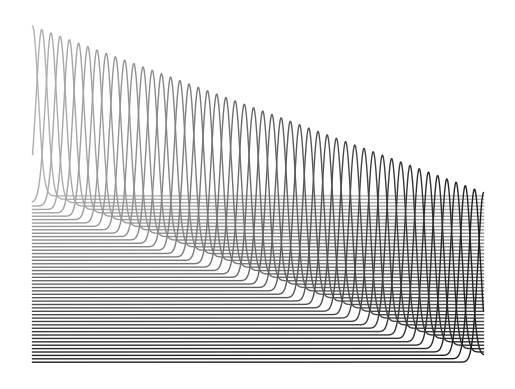

In [261]:
min_shade = 0.1
max_shade = 0.7
slope = (max_shade - min_shade)/num_ideal_timers
for i in range(num_ideal_timers):
    plt.plot(t, timers[i,:]-0.02*i, c=(max_shade - slope*i,)*3, lw=1);
    # plt.plot(t, timers[i,:], c=(max_shade - slope*i,)*3, lw=1);
plt.axis('off')
# plt.savefig(os.getcwd()+'/figure plots/timer_bank.pdf')

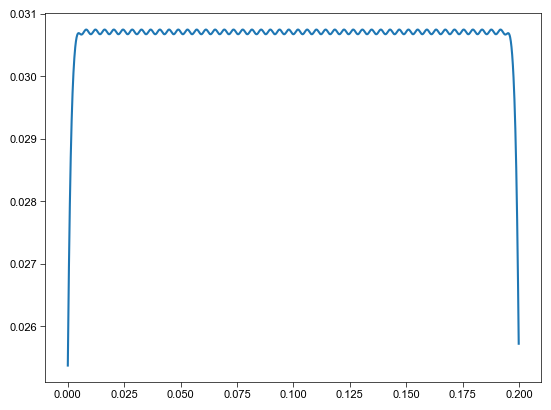

In [262]:
plt.plot(t, 1/num_ideal_timers*np.sum(timers, axis=0))

In [413]:
def selectionFixed(v_initial, get_interval, its=5000000, dv = 1e-4, report_its = 10000):
    """Simulate ATTRAP with fixed update method of timer selection mechanism.
    
    Arguments:
    v_initial -- initial vector of eligibility coupling weights
    distr -- distribution of PF/CF intervals
    its -- total number of PF/CF presentations (iterations) to simulate
    dv -- "Delta", the amount by which to decrease coupling weights for inactive timers
    report_its -- Frequency (in iterations) of reporting output weight vector
    
    Returns:
    v -- final weight vector
    v_all -- weight vector reported at intervals specified by report_its
    """
    
    # cdf = np.cumsum(distr/np.sum(distr))

    # Use CDF to draw intervals randomly from distribution given uniform random variables (see Methods)
    # get_interval = lambda r: np.interp(r, cdf, t)
    # get_interval_NN = lambda r: np.array(np.round(get_interval(r)*10000)/10000/dt, dtype=int)
    
    # Used for reporting weight values periodically
    report_counter = 0
    report_index = 0

    num_states = timers.shape[0]
    active_v_threshold = dv/num_states

    # num_updates = np.zeros(num_states)

    v_all = np.zeros((num_states, int(its/report_its)))
    v = np.copy(v_initial)

    for it in tqdm.notebook.trange(its, leave=False):
        # Calculate values of most active basis function
        # given random draw of PF/CF interval
        spike_ind = np.digitize(get_interval(rng.random()), t)-1
        timer_vals = timers[:,spike_ind]

        # Get index of most active timer
        active_timer = np.argmax(timer_vals)

        # Shouldn't end up with negative weights
        timers_to_update = (v>0)
        timers_to_update[active_timer] = False
        num_active_timers = np.sum(timers_to_update)

        if num_active_timers > 0:
            dv_minus = np.zeros(num_states)
            # Decrease coupling weights of all timers except the most active (ind_to_increase)
            dv_minus[timers_to_update] = np.minimum(v[timers_to_update], dv)
            dv_minus[active_timer] = 0

            # Add weight changes
            v -= dv_minus
            
            v[active_timer] += np.sum(dv_minus)

        report_counter += 1
        # Save current weight vector periodically
        if report_counter == report_its:
            v_all[:, report_index] = np.copy(v)
            report_counter = 0
            report_index += 1
    return v, v_all

## i -- unimodal

In [250]:
v_initial = np.zeros(num_ideal_timers)
v_initial[0] = 1

v_fixed_ideal, v_fixed_ideal_all = selectionFixed(v_initial, get_interval_uni, its=2000000, report_its=10000, dv=1e-5)

  0%|          | 0/2000000 [00:00<?, ?it/s]

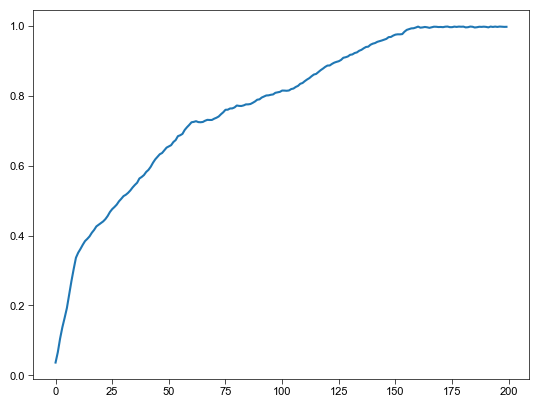

In [251]:
plt.plot(v_fixed_ideal_all[np.argmax(v_fixed_ideal),:])

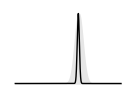

In [252]:
plt.figure(figsize=(1.5,1))
plt.fill_between(t, np.zeros(len(t)), uni_distr, color=(0.9,)*3)
plt.axis('off')
ax = plt.twinx()
# ax.plot(t, idealized_integrator(t, t_p_init_avg), c='k')
ax.plot(t, v_fixed_ideal@timers, c='k',lw=1)
plt.axis('off');
plt.savefig('figures/unimodal-mode-ideal.pdf')

## ii -- bimodal

In [253]:
v_initial = np.zeros(num_ideal_timers)
v_initial[0] = 1

v_fixed_ideal, v_fixed_ideal_all = selectionFixed(v_initial, get_interval_bi, its=2000000, report_its=10000, dv=1e-5)

  0%|          | 0/2000000 [00:00<?, ?it/s]

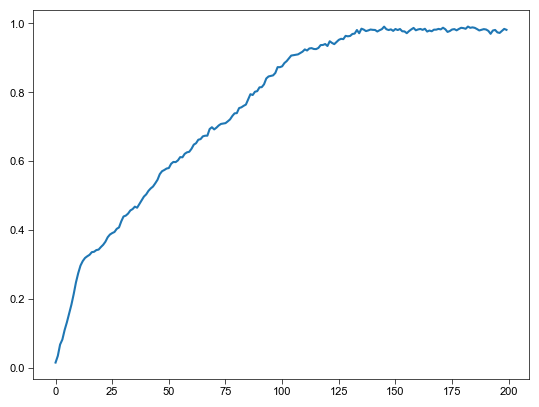

In [254]:
plt.plot(v_fixed_ideal_all[np.argmax(v_fixed_ideal),:])

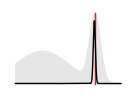

In [256]:
plt.figure(figsize=(1.5,1))
plt.fill_between(t, np.zeros(len(t)), bimodal_distr, color=(0.9,)*3)
plt.axis('off')
ax = plt.twinx()
# ax.plot(t, idealized_integrator(t, t_p_init_avg), c='k')
plt.plot([0.15,]*2, [0,1.1], c='C3', lw=1)
ax.plot(t, v_fixed_ideal@timers, c='k',lw=1)
plt.axis('off');
plt.savefig('figures/bimodal-mode-ideal.pdf')

## iii -- peaked

In [257]:
v_initial = np.zeros(num_ideal_timers)
v_initial[0] = 1

v_fixed_ideal, v_fixed_ideal_all = selectionFixed(v_initial, get_interval_peaked, its=2000000, report_its=10000, dv=1e-5)

  0%|          | 0/2000000 [00:00<?, ?it/s]

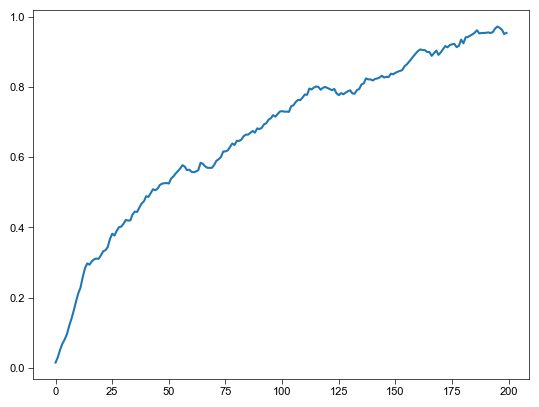

In [258]:
plt.plot(v_fixed_ideal_all[np.argmax(v_fixed_ideal),:])

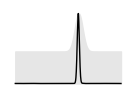

In [259]:
plt.figure(figsize=(1.5,1))
plt.fill_between(t, np.zeros(len(t)), peaked_distr, color=(0.9,)*3)
plt.axis('off')
ax = plt.twinx()
# ax.plot(t, idealized_integrator(t, t_p_init_avg), c='k')
# plt.plot([0.15,]*2, [0,1.1], c='C3', lw=1)
ax.plot(t, v_fixed_ideal@timers, c='k',lw=1)
plt.axis('off');
plt.savefig('figures/peaked-mode-ideal.pdf')

# iv -- empirical

In [414]:
v_initial = np.zeros(num_ideal_timers)
v_initial[0] = 1

v_fixed_ideal, v_fixed_ideal_all = selectionFixed(v_initial, get_interval_empirical, its=2000000, report_its=10000, dv=1e-5)

  0%|          | 0/2000000 [00:00<?, ?it/s]

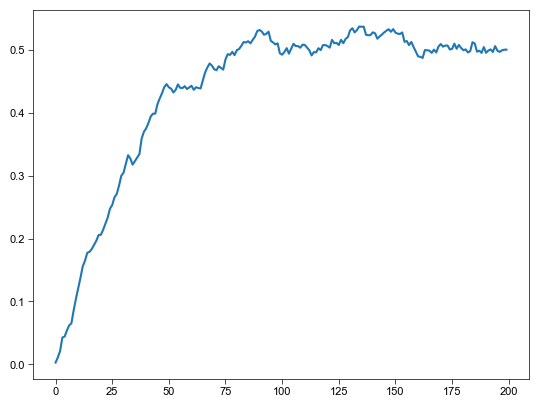

In [415]:
plt.plot(v_fixed_ideal_all[np.argmax(v_fixed_ideal),:])

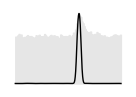

In [416]:
plt.figure(figsize=(1.5,1))
plt.fill_between(t[:-1], np.zeros(len(t)-1), empirical_pdf, color=(0.9,)*3)
# plt.fill_between(t, np.zeros(len(t)), peaked_distr, color=(0.9,)*3)
plt.axis('off')
ax = plt.twinx()
# ax.plot(t, idealized_integrator(t, t_p_init_avg), c='k')
# plt.plot([0.15,]*2, [0,1.1], c='C3', lw=1)
ax.plot(t, v_fixed_ideal@timers, c='k',lw=1)
plt.axis('off');
plt.savefig('figures/empirical-mode-ideal.pdf')

### Diagrams

In [328]:
num_ideal_timers = 9 # 16
# timer_std = 2.5e-3
timers = np.zeros((num_ideal_timers, len(t)))
edges = np.linspace(0, 0.2, num_ideal_timers+1)
for i in range(num_ideal_timers):
#     timers[i,:] = hill(np.exp(-(t - centers[i])**2/(2*timer_std**2)),0.5,10)
#     timers[i,:] /= np.max(timers[i,:])
    timers[i,int(edges[i]/dt):int(edges[i+1]/dt)] = 1

In [329]:
centers = edges[:-1] + (edges[1:]-edges[:-1])/2

In [330]:
v_0 = np.zeros(num_ideal_timers)
mid_timer = 5
v_0[mid_timer] = 0.75
v_0[-2] = 0.25

In [331]:
dv_window_mid = -v_0[mid_timer]*np.ones(num_ideal_timers)
dv_window_mid[mid_timer] = 1 - v_0[mid_timer]

dv_window_end = -v_0[-2]*np.ones(num_ideal_timers)
dv_window_end[-2] = 1 - v_0[-1]

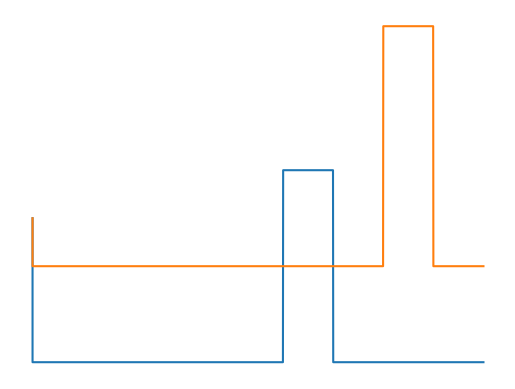

In [344]:
# plt.plot(np.concatenate(([0],t,[t[-1]])), np.concatenate(([0],dv_window_mid@timers,[0])))
# plt.plot(np.concatenate(([0],t,[t[-1]])), np.concatenate(([0],dv_window_end@timers,[0])))
plt.plot(np.concatenate(([0],t)), np.concatenate(([0],dv_window_mid@timers)))
plt.plot(np.concatenate(([0],t)), np.concatenate(([0],dv_window_end@timers)))
plt.axis('off')
plt.savefig('figures/proportional-diagram.pdf')

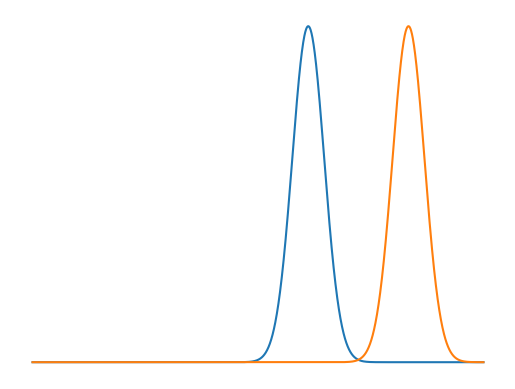

In [341]:
plt.plot(t, np.exp(-((t-centers[mid_timer])/0.01)**2))
plt.plot(t, np.exp(-((t-centers[-2])/0.01)**2))
plt.axis('off')
plt.savefig('figures/proportional-eligibility-diagram.pdf')
# plt.plot(np.concatenate(([0],t)), np.concatenate(([0],dv_window_mid@timers)))
# plt.plot(t, np.exp(-((t-centers[-1])/0.025)**2))

# Timer selection (shape)

In [417]:
def selectionProportional(v_initial, get_interval, its=5000000, dv = 1e-4, report_its = 10000):
    """Simulate ATTRAP with fixed update method of timer selection mechanism.
    
    Arguments:
    v_initial -- initial vector of eligibility coupling weights
    distr -- distribution of PF/CF intervals
    its -- total number of PF/CF presentations (iterations) to simulate
    dv -- "Delta", the amount by which to decrease coupling weights for inactive timers
    report_its -- Frequency (in iterations) of reporting output weight vector
    
    Returns:
    v -- final weight vector
    v_all -- weight vector reported at intervals specified by report_its
    """
    
    # cdf = np.cumsum(distr/np.sum(distr))

    # Use CDF to draw intervals randomly from distribution given uniform random variables (see Methods)
    # get_interval = lambda r: np.interp(r, cdf, t)
    # get_interval_NN = lambda r: np.array(np.round(get_interval(r)*10000)/10000/dt, dtype=int)
    
    # Used for reporting weight values periodically
    report_counter = 0
    report_index = 0

    num_states = timers.shape[0]
    active_v_threshold = dv/num_states

    # num_updates = np.zeros(num_states)

    v_all = np.zeros((num_states, int(its/report_its)))
    v = np.copy(v_initial)

    for it in tqdm.notebook.trange(its, leave=False):
        # Calculate values of most active basis function
        # given random draw of PF/CF interval
        spike_ind = np.digitize(get_interval(rng.random()), t)-1
        timer_vals = timers[:,spike_ind]

        # Get index of most active timer
        active_timer = np.argmax(timer_vals)
        
        # Update weights
        v_ = v*(1-dv)
        v_[active_timer] = v[active_timer] + dv*(1-v[active_timer])
        v = np.copy(v_)
        
        report_counter += 1
        # Save current weight vector periodically
        if report_counter == report_its:
            v_all[:, report_index] = np.copy(v)
            report_counter = 0
            report_index += 1
    return v, v_all

## i -- unimodal

In [281]:
v_initial = np.zeros(num_ideal_timers)
v_initial[0] = 1

v_proportional_ideal, v_proportional_all = selectionProportional(v_initial, get_interval_uni, its=2000000, report_its=10000, dv=1e-5)

  0%|          | 0/2000000 [00:00<?, ?it/s]

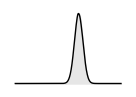

In [283]:
plt.figure(figsize=(1.5,1))
plt.fill_between(t, np.zeros(len(t)), uni_distr, color=(0.9,)*3)
plt.axis('off')
ax = plt.twinx()
# ax.plot(t, idealized_integrator(t, t_p_init_avg), c='k')
ax.plot(t, v_proportional_ideal@timers, c='k',lw=1)
plt.axis('off');
plt.savefig('figures/unimodal-shape-ideal.pdf')

## ii -- bimodal

In [284]:
v_initial = np.zeros(num_ideal_timers)
v_initial[0] = 1

v_proportional_ideal, v_proportional_all = selectionProportional(v_initial, get_interval_bi, its=2000000, report_its=10000, dv=1e-5)

  0%|          | 0/2000000 [00:00<?, ?it/s]

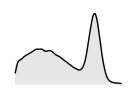

In [285]:
plt.figure(figsize=(1.5,1))
plt.fill_between(t, np.zeros(len(t)), bimodal_distr, color=(0.9,)*3)
plt.axis('off')
ax = plt.twinx()
# ax.plot(t, idealized_integrator(t, t_p_init_avg), c='k')
ax.plot(t, v_proportional_ideal@timers, c='k',lw=1)
plt.axis('off');
plt.savefig('figures/bimodal-shape-ideal.pdf')

## iii -- peaked

In [288]:
v_initial = np.zeros(num_ideal_timers)
v_initial[0] = 1

v_proportional_ideal, v_proportional_all = selectionProportional(v_initial, get_interval_peaked, its=3000000, report_its=10000, dv=1e-5)

  0%|          | 0/3000000 [00:00<?, ?it/s]

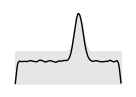

In [289]:
plt.figure(figsize=(1.5,1))
plt.fill_between(t, np.zeros(len(t)), peaked_distr, color=(0.9,)*3)
plt.axis('off')
ax = plt.twinx()
# ax.plot(t, idealized_integrator(t, t_p_init_avg), c='k')
ax.plot(t, v_proportional_ideal@timers, c='k',lw=1)
plt.axis('off');
plt.savefig('figures/peaked-shape-ideal.pdf')

## iv -- empirical

In [418]:
v_initial = np.zeros(num_ideal_timers)
v_initial[0] = 1

v_proportional_ideal, v_proportional_all = selectionProportional(v_initial, get_interval_empirical, its=3000000, report_its=10000, dv=1e-5)

  0%|          | 0/3000000 [00:00<?, ?it/s]

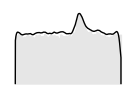

In [422]:
plt.figure(figsize=(1.5,1))
plt.fill_between(t[:-1], np.zeros(len(t)-1), empirical_pdf, color=(0.9,)*3)
plt.axis('off')
ax = plt.twinx()
# ax.plot(t, idealized_integrator(t, t_p_init_avg), c='k')
ax.plot(np.concatenate(([0], t, [t[-1]])), np.concatenate(([0],v_proportional_ideal@timers,[0])), c='k',lw=1)
plt.axis('off');
plt.savefig('figures/empirical-shape-ideal.pdf')